# Quality control reporting

## Import libraries

In [ ]:
# Load necessary packages
suppressPackageStartupMessages({
    library(arrow)
    library(ggplot2)
    library(dplyr)
    library(tidyr)
    library(colorspace)
})

# Get the current working directory and find Git root
find_git_root <- function() {
    # Get current working directory
    cwd <- getwd()

    # Check if current directory has .git
    if (dir.exists(file.path(cwd, ".git"))) {
        return(cwd)
    }

    # If not, search parent directories
    current_path <- cwd
    while (dirname(current_path) != current_path) {  # While not at root
        parent_path <- dirname(current_path)
        if (dir.exists(file.path(parent_path, ".git"))) {
            return(parent_path)
        }
        current_path <- parent_path
    }

    # If no Git root found, stop with error
    stop("No Git root directory found.")
}

# Find the Git root directory
root_dir <- find_git_root()
cat("Git root directory:", root_dir, "\n")


Warning message:
“package ‘arrow’ was built under R version 4.2.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘colorspace’ was built under R version 4.2.3”


## Set up directory for plots

In [ ]:
# Set up directory for plots
figures_dir <- file.path(root_dir, "1.image_quality_control", "qc_figures")

# Create the directory if it doesn't exist
if (!dir.exists(figures_dir)) {
    dir.create(figures_dir)
}


## Load in the QC results 

In [ ]:
# Load all plate files from the qc_flag_files directory
qc_flag_files <- list.files(file.path(root_dir, "1.image_quality_control", "qc_flag_files"), pattern = "\\.parquet$", full.names = TRUE)
qc_flag_files <- qc_flag_files[!grepl("NF0017", qc_flag_files)]

# Read and concatenate all plate files into a single dataframe
qc_results_df <- do.call(rbind, lapply(qc_flag_files, read_parquet))

# Check for any NaNs in the columns starting with Metadata_
metadata_cols <- grep("^Metadata_", colnames(qc_results_df), value = TRUE)
na_counts <- sapply(qc_results_df[metadata_cols], function(x) sum(is.na(x)))

# Print the count of NaNs for each Metadata_ column
na_counts

# Look at the dimensions and head of the dataframe
dim(qc_results_df)
head(qc_results_df)


Metadata_Plate   Metadata_Well   Metadata_Site Metadata_Zslice 
              0               0               0               0

[1] 29870    14

Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Zslice,Blurry_DNA,Blurry_Mito,Blurry_AGP,Blurry_Brightfield,Blurry_ER,Saturated_DNA,Saturated_Mito,Saturated_AGP,Saturated_Brightfield,Saturated_ER
<chr>,<chr>,<dbl>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
NF0014,C10,1,ZS000,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
NF0014,C10,1,ZS001,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
NF0014,C10,1,ZS002,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
NF0014,C10,1,ZS003,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
NF0014,C10,1,ZS004,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
NF0014,C10,1,ZS005,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


## Melt dataframe to reduce columns

In [4]:
condition_cols <- grep("Blurry|Saturated", colnames(qc_results_df), value = TRUE)

# Assuming qc_results_df is your dataframe and condition_cols is a vector of column names
melted_qc_df <- qc_results_df %>%
  pivot_longer(
    cols = all_of(condition_cols),
    names_to = c("Condition", "Channel"),
    names_sep = "_",
    values_to = "Failed"
  )

dim(melted_qc_df)
head(melted_qc_df)


[1] 298700      7

Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Zslice,Condition,Channel,Failed
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<lgl>
NF0014,C10,1,ZS000,Blurry,DNA,FALSE
NF0014,C10,1,ZS000,Blurry,Mito,FALSE
NF0014,C10,1,ZS000,Blurry,AGP,FALSE
NF0014,C10,1,ZS000,Blurry,Brightfield,FALSE
NF0014,C10,1,ZS000,Blurry,ER,FALSE
NF0014,C10,1,ZS000,Saturated,DNA,FALSE


## Generate count per condition and channel

In [5]:
# Extract the condition and channel information from the column names
conditions_channels <- data.frame(
    Condition = sub("_(.*)", "", condition_cols),
    Channel = sub("^(Blurry|Saturated)_(.*)", "\\2", condition_cols),
    Column = condition_cols
)

# Calculate the counts of failed z-slices for each condition and channel
failed_counts <- conditions_channels %>%
    rowwise() %>%
    mutate(
        # Construct the column name by combining Condition and Channel
        Column = paste(Condition, Channel, sep = "_"),

        # Sum the counts of failed z-slices in the constructed column
        Count = sum(qc_results_df[[Column]] > 0, na.rm = TRUE)
    ) %>%
    select(-Column) %>%
    ungroup()

# Show dimension and head of failed counts dataframe
dim(failed_counts)
head(failed_counts)


[1] 10  3

Condition,Channel,Count
<chr>,<chr>,<int>
Blurry,DNA,169
Blurry,Mito,521
Blurry,AGP,146
Blurry,Brightfield,566
Blurry,ER,142
Saturated,DNA,111


## Plot the count of failed z-slices across channel and condition

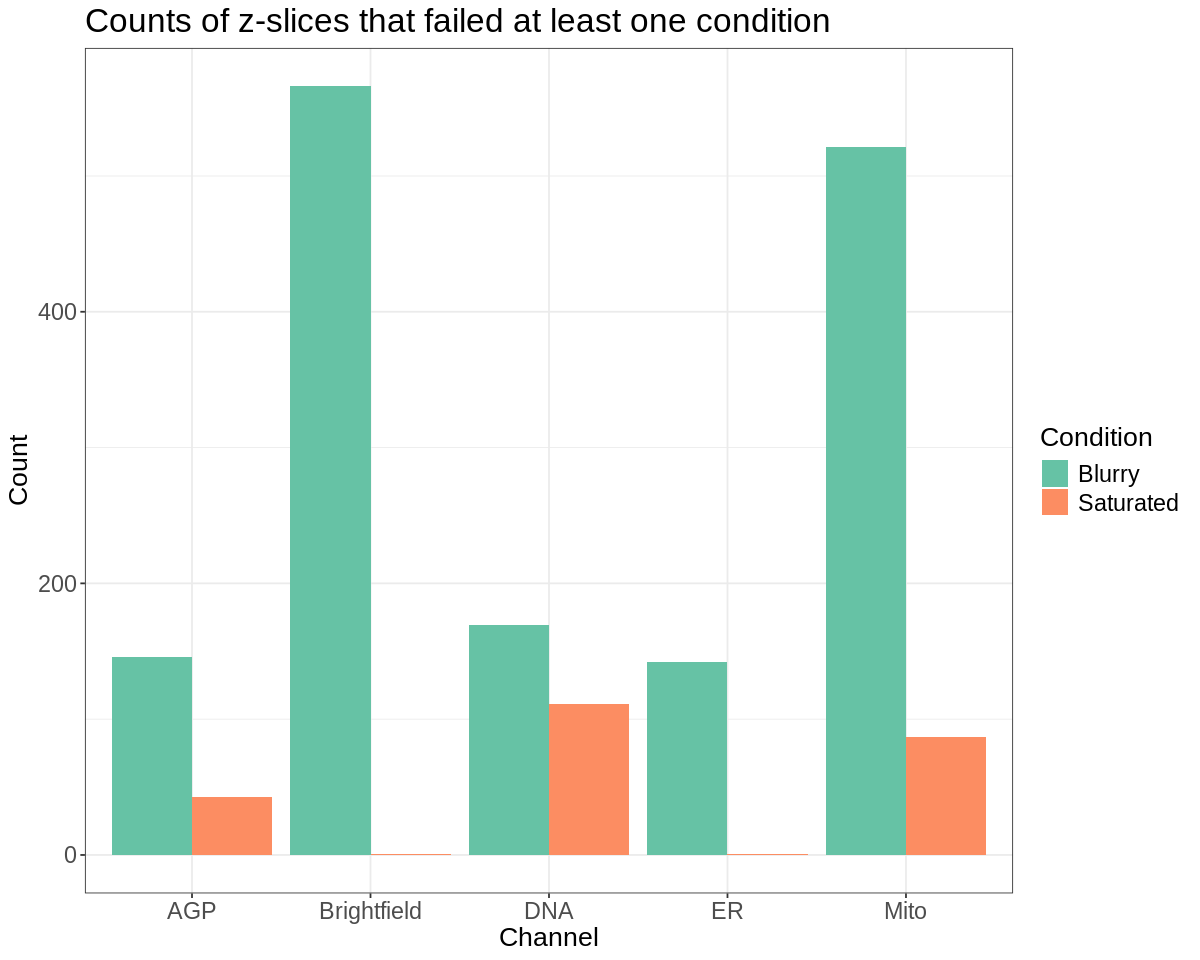

In [6]:
# Set width and height
width <- 10
height <- 8
options(repr.plot.width = width, repr.plot.height = height)

# Plot the bar chart of counts of failed z-slices for each condition and channel
count_zslices_channel <- ggplot(failed_counts, aes(x = Channel, y = Count, fill = Condition)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_fill_brewer(palette = "Set2") +
    labs(
        title = "Counts of z-slices that failed at least one condition",
        x = "Channel",
        y = "Count"
    ) +
    theme_bw() +
    theme(
        plot.title = element_text(size = 20),
        axis.title = element_text(size = 16),
        axis.text = element_text(size = 14),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14)
    )

# Show plot
print(count_zslices_channel)

# Save plot
ggsave(file.path(figures_dir, "count_zslices_channel.png"), plot = count_zslices_channel, width = width, height = height, dpi = 500)


## Calculate number of z-slices failed per slice

In [7]:
# Group by Metadata_Zslice, Condition, and Channel, then summarize the number of failed zslices
failed_zslices_per_metadata <- melted_qc_df %>%
    group_by(Metadata_Zslice, Condition, Channel) %>%
    summarize(Failed_Count = sum(Failed == TRUE, na.rm = TRUE)) %>% # Explicitly count TRUE values
    ungroup()

# Show dimension and head of the resulting dataframe
dim(failed_zslices_per_metadata)
head(failed_zslices_per_metadata)


`summarise()` has grouped output by 'Metadata_Zslice', 'Condition'. You can
override using the `.groups` argument.


[1] 650   4

Metadata_Zslice,Condition,Channel,Failed_Count
<chr>,<chr>,<chr>,<int>
ZS000,Blurry,AGP,3
ZS000,Blurry,Brightfield,9
ZS000,Blurry,DNA,0
ZS000,Blurry,ER,0
ZS000,Blurry,Mito,15
ZS000,Saturated,AGP,1


## Plot the failed counts across each z-slice

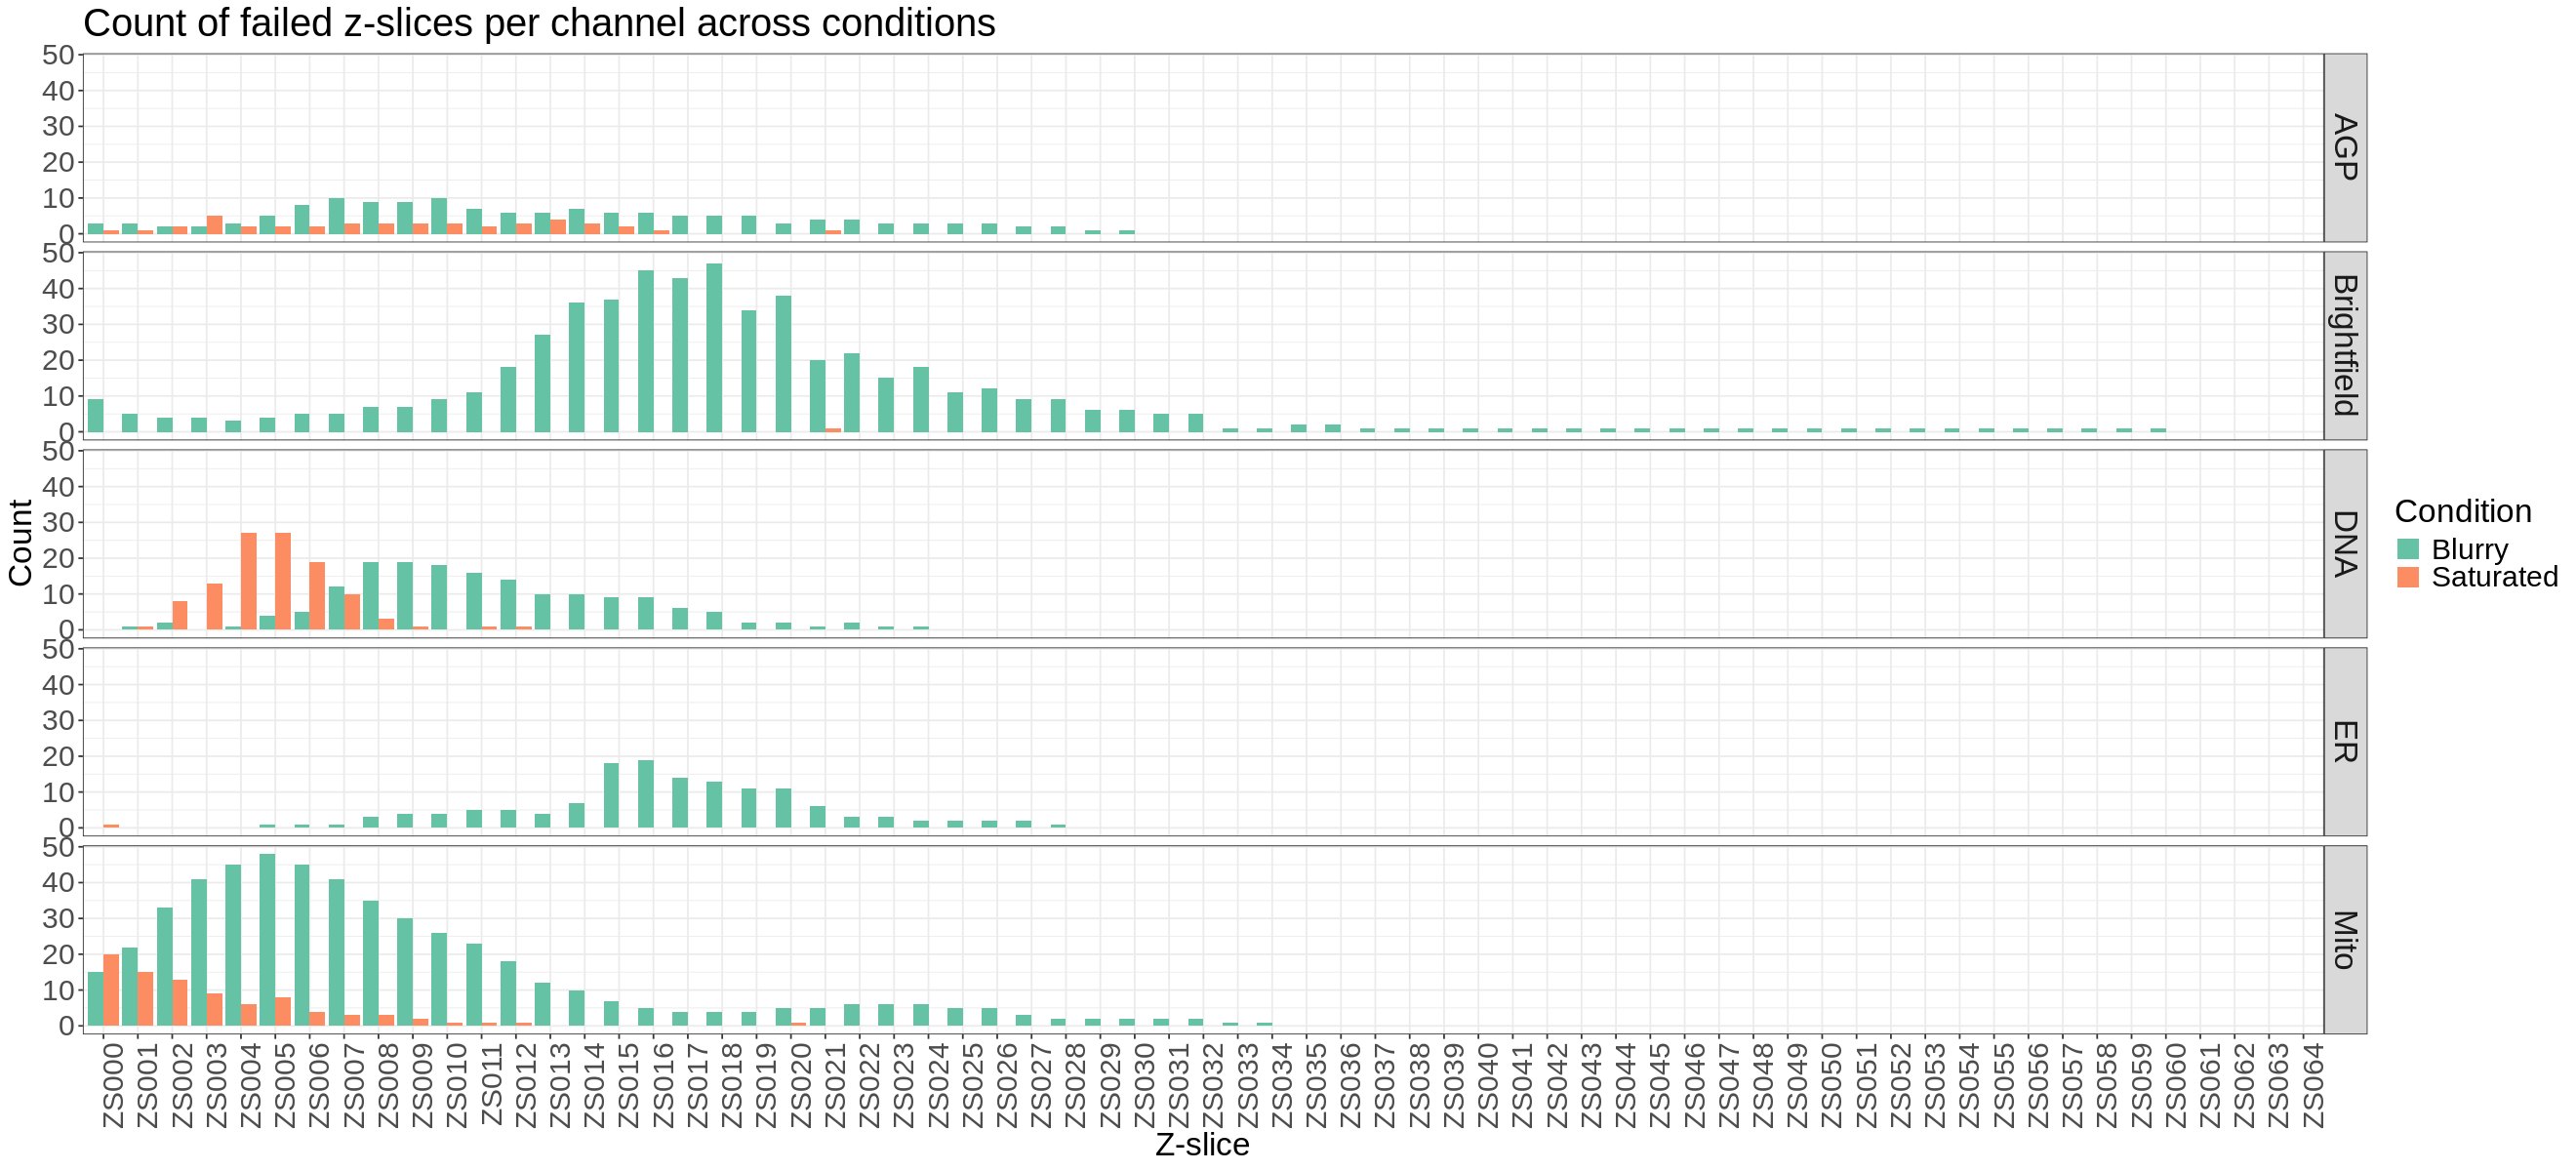

In [8]:
# Calculate the maximum Failed_Count across the entire dataset
max_failed_count <- max(failed_zslices_per_metadata$Failed_Count, na.rm = TRUE)

# Set width and height
width <- 22
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

# Create the bar plot with consistent y-axis limits
bar_plot <- ggplot(failed_zslices_per_metadata, aes(x = Metadata_Zslice, y = Failed_Count, fill = Condition)) +
    geom_bar(stat = "identity", position = "dodge", linewidth = 2) +
    facet_grid(Channel ~ .) +
    scale_fill_brewer(palette = "Set2") +
    labs(
        title = "Count of failed z-slices per channel across conditions",
        x = "Z-slice",
        y = "Count"
    ) +
    theme_bw() +
    theme(
        plot.title = element_text(size = 24),
        axis.title = element_text(size = 20),
        axis.text.y = element_text(size = 18),
        axis.text.x = element_text(size = 18, angle = 90, hjust = 1),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 18),
        strip.text = element_text(size = 20)
    ) +
    ylim(0, max_failed_count)

# Show plot
print(bar_plot)

# Save plot
ggsave(file.path(figures_dir, "failed_zslice_count_channel_and_condition.png"), plot = bar_plot, width = width, height = height, dpi = 500)


## Plot the distribution of failed z-slices across normalized z-slice values

By normalizing, we will be able to get a better compare the counts across the z-slices when at the same "level", where 0 still represents the top but 1 now represents the bottom for all organoids.

In [9]:
# Step 1: Remove duplicates for z-slices per organoid (Plate, Well, Site, Zslice)
unique_zslices <- melted_qc_df %>%
    distinct(Metadata_Plate, Metadata_Well, Metadata_Site, Metadata_Zslice) %>%
    mutate(Numeric_Zslice = as.numeric(gsub("ZS", "", Metadata_Zslice)))

# Step 2: Normalize the z-slices per organoid
normalized_zslices <- unique_zslices %>%
    group_by(Metadata_Plate, Metadata_Well, Metadata_Site) %>%
    mutate(
        Normalized_Zslice = (Numeric_Zslice - min(Numeric_Zslice)) /
            (max(Numeric_Zslice) - min(Numeric_Zslice))
    ) %>%
    ungroup()

# Step 3: Join the normalized z-slices back to the original dataframe
norm_melted_qc_df <- melted_qc_df %>%
    left_join(normalized_zslices, by = c("Metadata_Plate", "Metadata_Well", "Metadata_Site", "Metadata_Zslice"))

# Step 4: Inspect the result
dim(norm_melted_qc_df)
head(norm_melted_qc_df)


[1] 298700      9

Metadata_Plate,Metadata_Well,Metadata_Site,Metadata_Zslice,Condition,Channel,Failed,Numeric_Zslice,Normalized_Zslice
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<dbl>
NF0014,C10,1,ZS000,Blurry,DNA,FALSE,0,0
NF0014,C10,1,ZS000,Blurry,Mito,FALSE,0,0
NF0014,C10,1,ZS000,Blurry,AGP,FALSE,0,0
NF0014,C10,1,ZS000,Blurry,Brightfield,FALSE,0,0
NF0014,C10,1,ZS000,Blurry,ER,FALSE,0,0
NF0014,C10,1,ZS000,Saturated,DNA,FALSE,0,0


In [10]:
# Group by Metadata_Zslice, Condition, Plate, and Channel, then summarize the number of failed zslices
norm_failed_zslices_per_metadata <- norm_melted_qc_df %>%
    group_by(Normalized_Zslice, Condition, Metadata_Plate, Channel) %>%
    summarize(Failed_Count = sum(Failed == TRUE, na.rm = TRUE)) %>% # Explicitly count TRUE values
    ungroup()

# Show dimension and head of the resulting dataframe
dim(norm_failed_zslices_per_metadata)
head(norm_failed_zslices_per_metadata)


`summarise()` has grouped output by 'Normalized_Zslice', 'Condition',
'Metadata_Plate'. You can override using the `.groups` argument.


[1] 23540     5

Normalized_Zslice,Condition,Metadata_Plate,Channel,Failed_Count
<dbl>,<chr>,<chr>,<chr>,<int>
0,Blurry,NF0014,AGP,0
0,Blurry,NF0014,Brightfield,0
0,Blurry,NF0014,DNA,0
0,Blurry,NF0014,ER,0
0,Blurry,NF0014,Mito,3
0,Blurry,NF0016,AGP,2


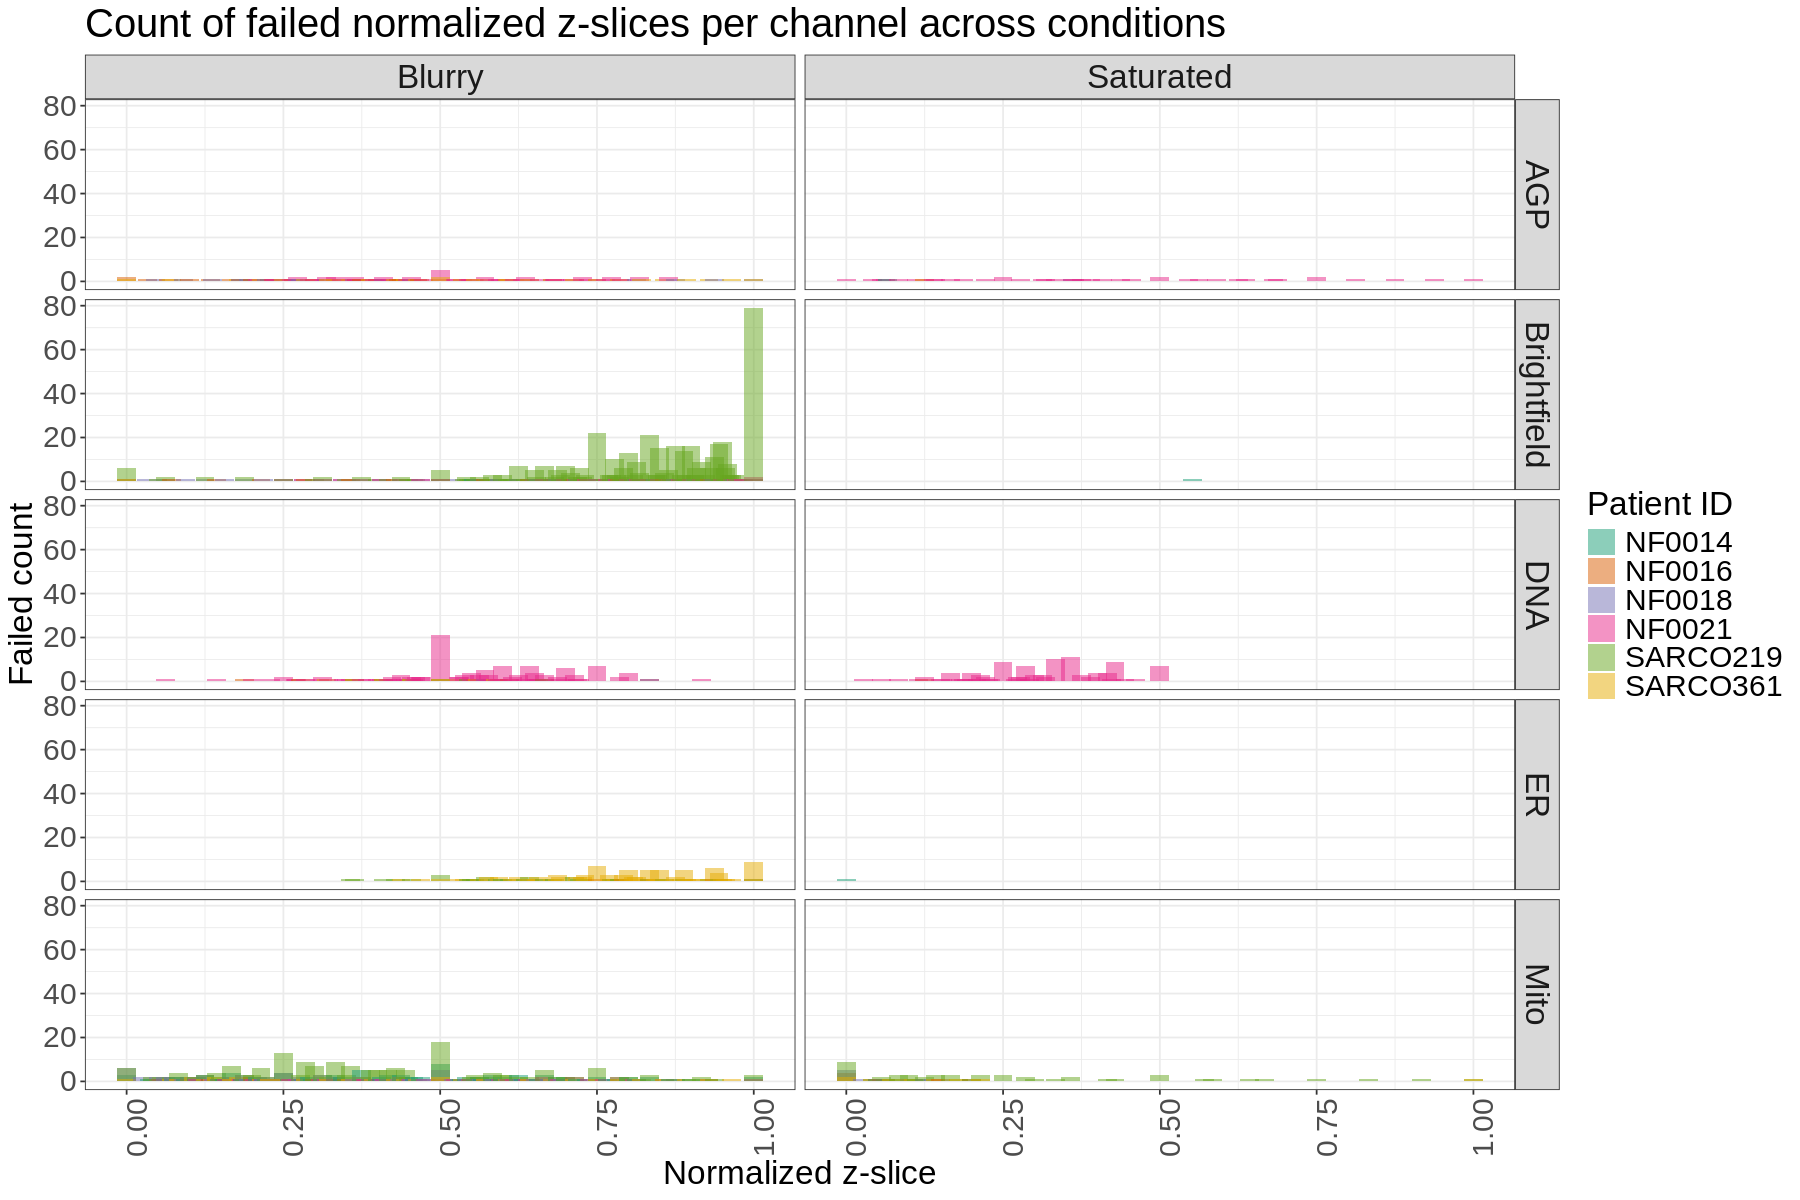

In [11]:
# Set width and height
width <- 15
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

# Create the bar plot using Failed_Count
histogram_plot <- ggplot(norm_failed_zslices_per_metadata, aes(x = Normalized_Zslice, y = Failed_Count, fill = Metadata_Plate)) +
    geom_bar(stat = "identity", alpha = 0.5, position = "identity", width = 0.03) +
    facet_grid(Channel ~ Condition) +
    scale_fill_brewer(palette = "Dark2") +
    labs(
        title = "Count of failed normalized z-slices per channel across conditions",
        x = "Normalized z-slice",
        y = "Failed count",
        fill = "Patient ID"
    ) +
    theme_bw() +
    theme(
        plot.title = element_text(size = 24),
        axis.title = element_text(size = 20),
        axis.text.y = element_text(size = 18),
        axis.text.x = element_text(size = 18, angle = 90, hjust = 1),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 18),
        strip.text = element_text(size = 20)
    )

# Show plot
print(histogram_plot)

# Save plot
ggsave(file.path(figures_dir, "failed_norm_zslice_count_channel_and_condition.png"), plot = histogram_plot, width = width, height = height, dpi = 500)


## Determine number of failed organoids based on failed z-slices and plot results

### Filter qc_results to only original QC dataframe to only detect rows with at least one failed z-slice and group by plate/well/site or organoid-level 

In [12]:
# Filter the dataframe for rows where any of the condition columns are TRUE
failed_zslices_df <- qc_results_df[apply(qc_results_df[condition_cols], 1, any), ]

# Count the unique combinations of Metadata_Plate, Metadata_Well, and Metadata_Site
unique_failed_organoids <- failed_zslices_df %>%
  select(Metadata_Plate, Metadata_Well, Metadata_Site) %>%
  distinct()

# Print the number of unique failed organoids
total_unique_organoids <- nrow(unique_failed_organoids)
cat("Total unique organoids that would fail:", total_unique_organoids, "\n")

# Calculate and print the percentage of unique failed organoids out of the total
total_organoids <- qc_results_df %>%
  select(Metadata_Plate, Metadata_Well, Metadata_Site) %>%
  distinct() %>%
  nrow()

percentage_failed <- (total_unique_organoids / total_organoids) * 100
cat("Percentage of unique organoids that would fail:", round(percentage_failed, 2), "%\n")

dim(unique_failed_organoids)
head(unique_failed_organoids)


Total unique organoids that would fail: 292 
Percentage of unique organoids that would fail: 22.83 %


[1] 292   3

Metadata_Plate,Metadata_Well,Metadata_Site
<chr>,<chr>,<dbl>
NF0014,C2,2
NF0014,C9,1
NF0014,D2,2
NF0014,D5,1
NF0014,D6,1
NF0014,D8,2


### Determine the counts of failed z-slices per organoid

In [13]:
# Count the number of failing z-slices per organoid
failed_zslices_per_organoid <- failed_zslices_df %>%
  group_by(Metadata_Plate, Metadata_Well, Metadata_Site) %>%
  summarise(failed_zslices_count = n(), .groups = "drop")

# Organize organoids by the number of failing z-slices
failed_more_than_1 <- failed_zslices_per_organoid %>%
  filter(failed_zslices_count > 1)

failed_1 <- failed_zslices_per_organoid %>%
  filter(failed_zslices_count == 1)

# Print the number of organoids that have more than 1 failing z-slices
cat("Number of organoids with more than 1 failing z-slices:", nrow(failed_more_than_1), "\n")

# Print the number of organoids that have 1 failing z-slices
cat("Number of organoids with 1 failing z-slices:", nrow(failed_1), "\n")


Number of organoids with more than 1 failing z-slices: 242 
Number of organoids with 1 failing z-slices: 50 


### Add new column for number of z-slices failed to the organoid dataframe

In [14]:
failed_zslices_per_organoid <- failed_zslices_per_organoid %>%
    left_join(
        failed_1 %>%
            select(-failed_zslices_count) %>%
            mutate(number_failed_zslices = "only 1 failed"),
        by = c("Metadata_Plate", "Metadata_Well", "Metadata_Site")
    ) %>%
    left_join(
        failed_more_than_1 %>%
            select(-failed_zslices_count) %>%
            mutate(number_failed_zslices = "more than 1 failed"),
        by = c("Metadata_Plate", "Metadata_Well", "Metadata_Site")
    ) %>%
    mutate(
        number_failed_zslices = coalesce(number_failed_zslices.x, number_failed_zslices.y)
    ) %>%
    select(-number_failed_zslices.x, -number_failed_zslices.y)

# Inspect dimensions and data
dim(failed_zslices_per_organoid)
head(failed_zslices_per_organoid)


[1] 292   5

Metadata_Plate,Metadata_Well,Metadata_Site,failed_zslices_count,number_failed_zslices
<chr>,<chr>,<dbl>,<int>,<chr>
NF0014,C2,2,5,more than 1 failed
NF0014,C9,1,5,more than 1 failed
NF0014,D2,2,5,more than 1 failed
NF0014,D5,1,10,more than 1 failed
NF0014,D6,1,1,only 1 failed
NF0014,D8,2,24,more than 1 failed


## Load in platemap with treatment and dose information

In [15]:
# Load in platemap file
platemap_df <- read.csv("../../data/metadata/platemap.csv")

# Remove WellRow and WellCol columns
platemap_df <- platemap_df %>%
    select(-WellRow, -WellCol)

head(platemap_df)


,well_position,treatment,dose
,<chr>,<chr>,<int>
1,C2,STAURO,10
2,D2,Digoxin,1
3,E2,Digoxin,1
4,F2,Onalespib,1
5,G2,STAURO,10
6,C3,Onalespib,1


### Merge treatment to organoid data

In [16]:
# Merge treatment and dose information from platemap_df to unique_failed_organoids
unique_failed_organoids_treatment <- failed_zslices_per_organoid %>%
    left_join(platemap_df, by = c("Metadata_Well" = "well_position"))

# Merge treatment and dose into a new column
unique_failed_organoids_treatment <- unique_failed_organoids_treatment %>%
    mutate(Treatment_Dose = paste(treatment, dose, sep = "_"))

# Show the head of the merged dataframe
dim(unique_failed_organoids_treatment)
head(unique_failed_organoids_treatment)


[1] 292   8

Metadata_Plate,Metadata_Well,Metadata_Site,failed_zslices_count,number_failed_zslices,treatment,dose,Treatment_Dose
<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<int>,<chr>
NF0014,C2,2,5,more than 1 failed,STAURO,10,STAURO_10
NF0014,C9,1,5,more than 1 failed,Mirdametinib,10,Mirdametinib_10
NF0014,D2,2,5,more than 1 failed,Digoxin,1,Digoxin_1
NF0014,D5,1,10,more than 1 failed,Fimepinostat,1,Fimepinostat_1
NF0014,D6,1,1,only 1 failed,Imatinib,1,Imatinib_1
NF0014,D8,2,24,more than 1 failed,Binimetinib,10,Binimetinib_10


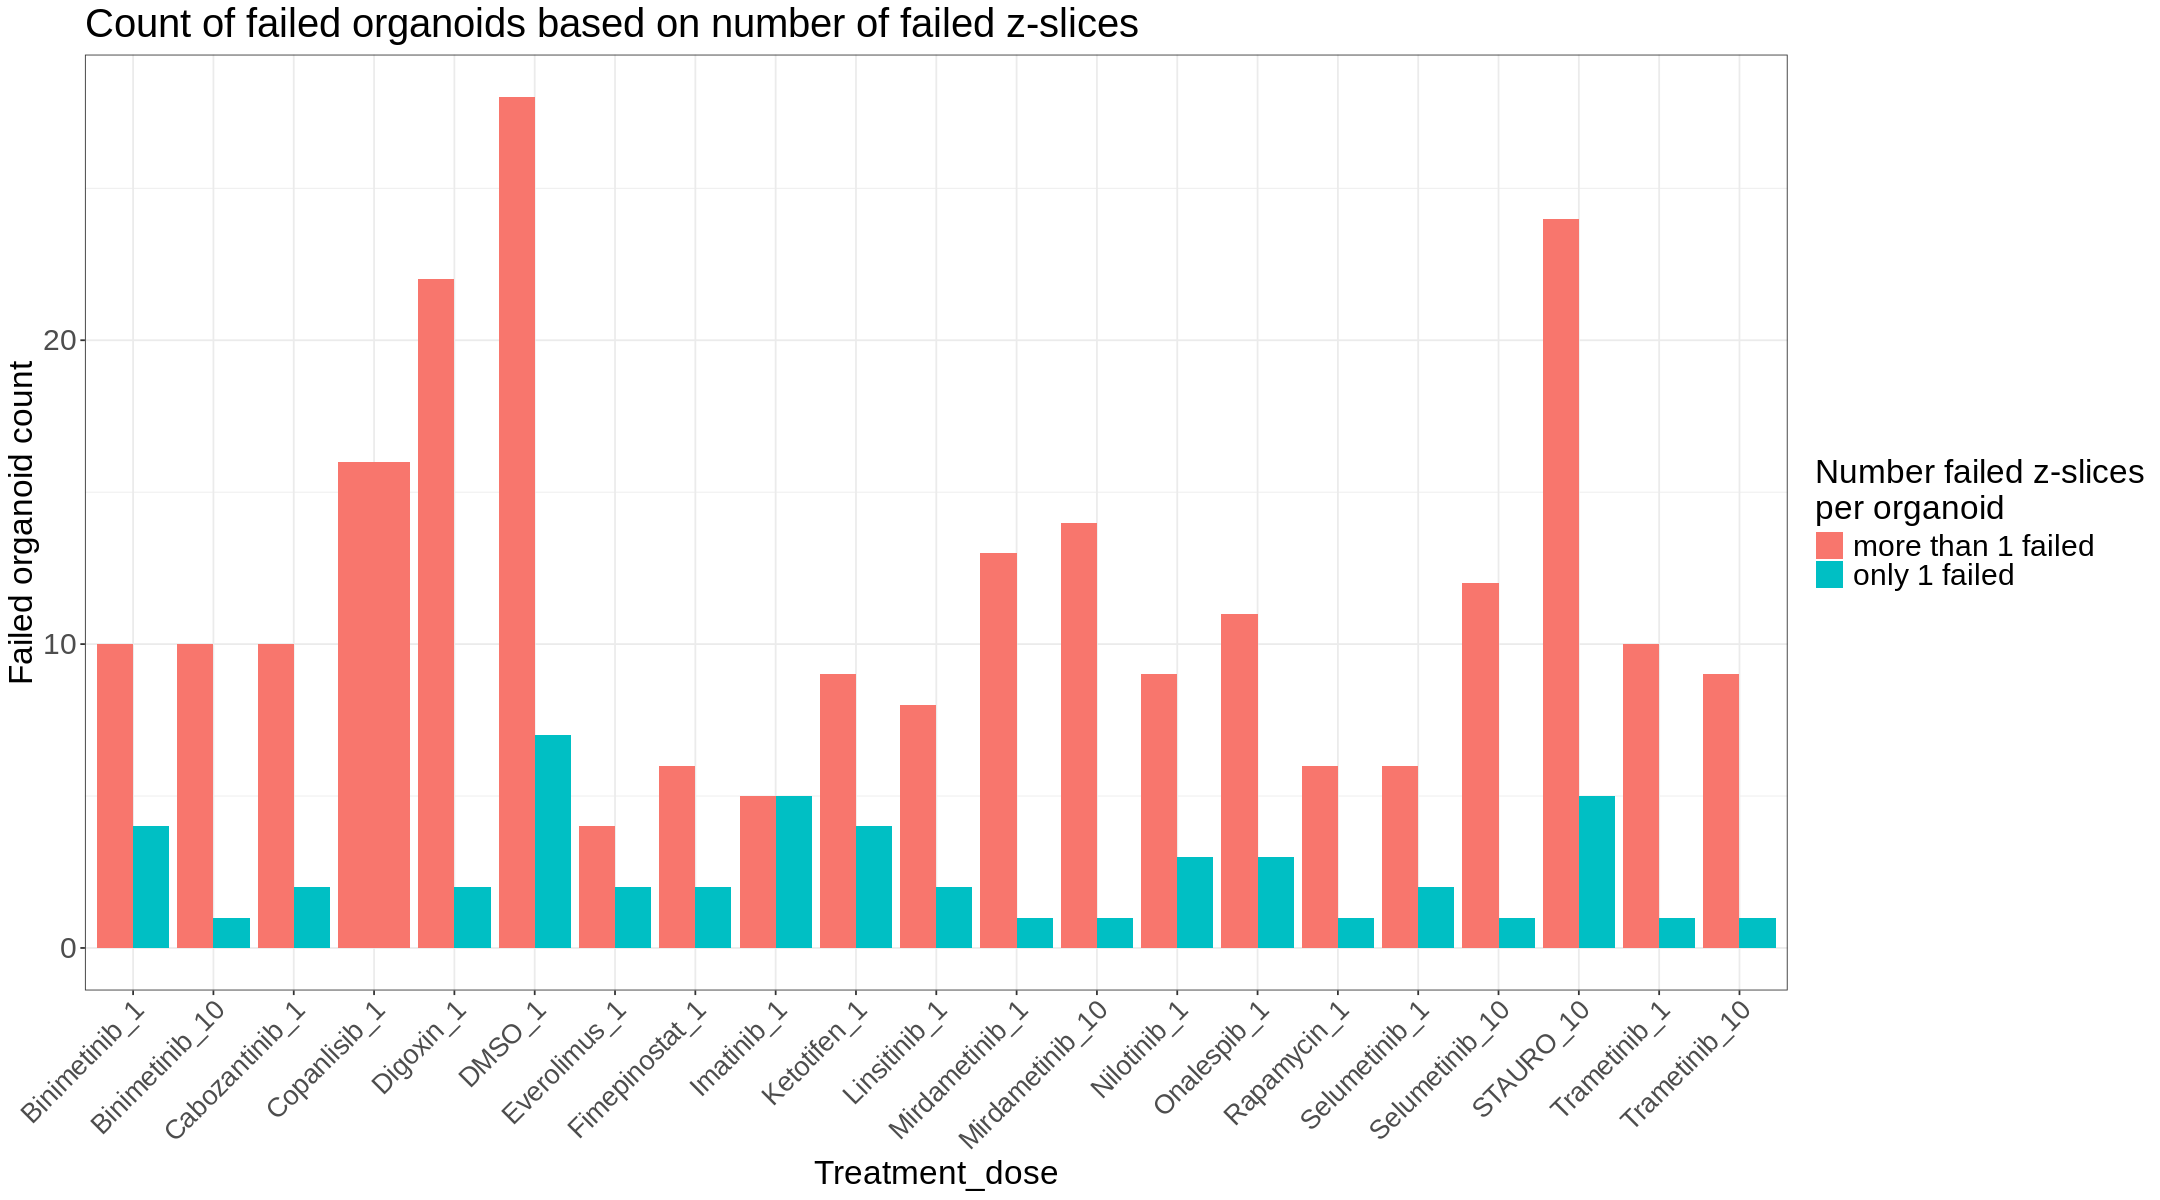

In [17]:
# Set width and height
width <- 18
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

# Create the bar plot
treatment_dose_failed_plot <- ggplot(unique_failed_organoids_treatment, aes(x = Treatment_Dose, fill = number_failed_zslices)) +
    geom_bar(position = "dodge") +
    labs(
        title = "Count of failed organoids based on number of failed z-slices",
        x = "Treatment_dose",
        y = "Failed organoid count",
        fill = "Number failed z-slices\nper organoid"
    ) +
    theme_bw() +
    theme(
        plot.title = element_text(size = 24),
        axis.title = element_text(size = 20),
        axis.text.y = element_text(size = 18),
        axis.text.x = element_text(size = 16, angle = 45, hjust = 1),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 18)
    )

# Show plot
print(treatment_dose_failed_plot)

# Save plot
ggsave(file.path(figures_dir, "failed_organoid_count_treatment_dose_number_failed_zslices.png"), plot = treatment_dose_failed_plot, width = width, height = height, dpi = 500)


In [18]:
# Get the total organoid count per plate
total_organoid_counts <- qc_results_df %>%
    select(Metadata_Plate, Metadata_Well, Metadata_Site) %>%
    distinct() %>%
    group_by(Metadata_Plate) %>%
    summarise(total_organoid_count = n(), .groups = "drop")

# Get the count of rows with the same treatment, dose, and plate
treatment_dose_counts <- unique_failed_organoids_treatment %>%
    group_by(Metadata_Plate, Treatment_Dose) %>%
    summarise(failed_organoid_count = n(), .groups = "drop") %>%
    left_join(total_organoid_counts, by = "Metadata_Plate") %>%
    mutate(proportion_failed = failed_organoid_count / total_organoid_count)

# Show the head of the resulting dataframe
dim(treatment_dose_counts)
head(treatment_dose_counts)


[1] 94  5

Metadata_Plate,Treatment_Dose,failed_organoid_count,total_organoid_count,proportion_failed
<chr>,<chr>,<int>,<int>,<dbl>
NF0014,Binimetinib_10,1,104,0.009615385
NF0014,Cabozantinib_1,1,104,0.009615385
NF0014,Copanlisib_1,1,104,0.009615385
NF0014,Digoxin_1,2,104,0.019230769
NF0014,DMSO_1,1,104,0.009615385
NF0014,Fimepinostat_1,1,104,0.009615385


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


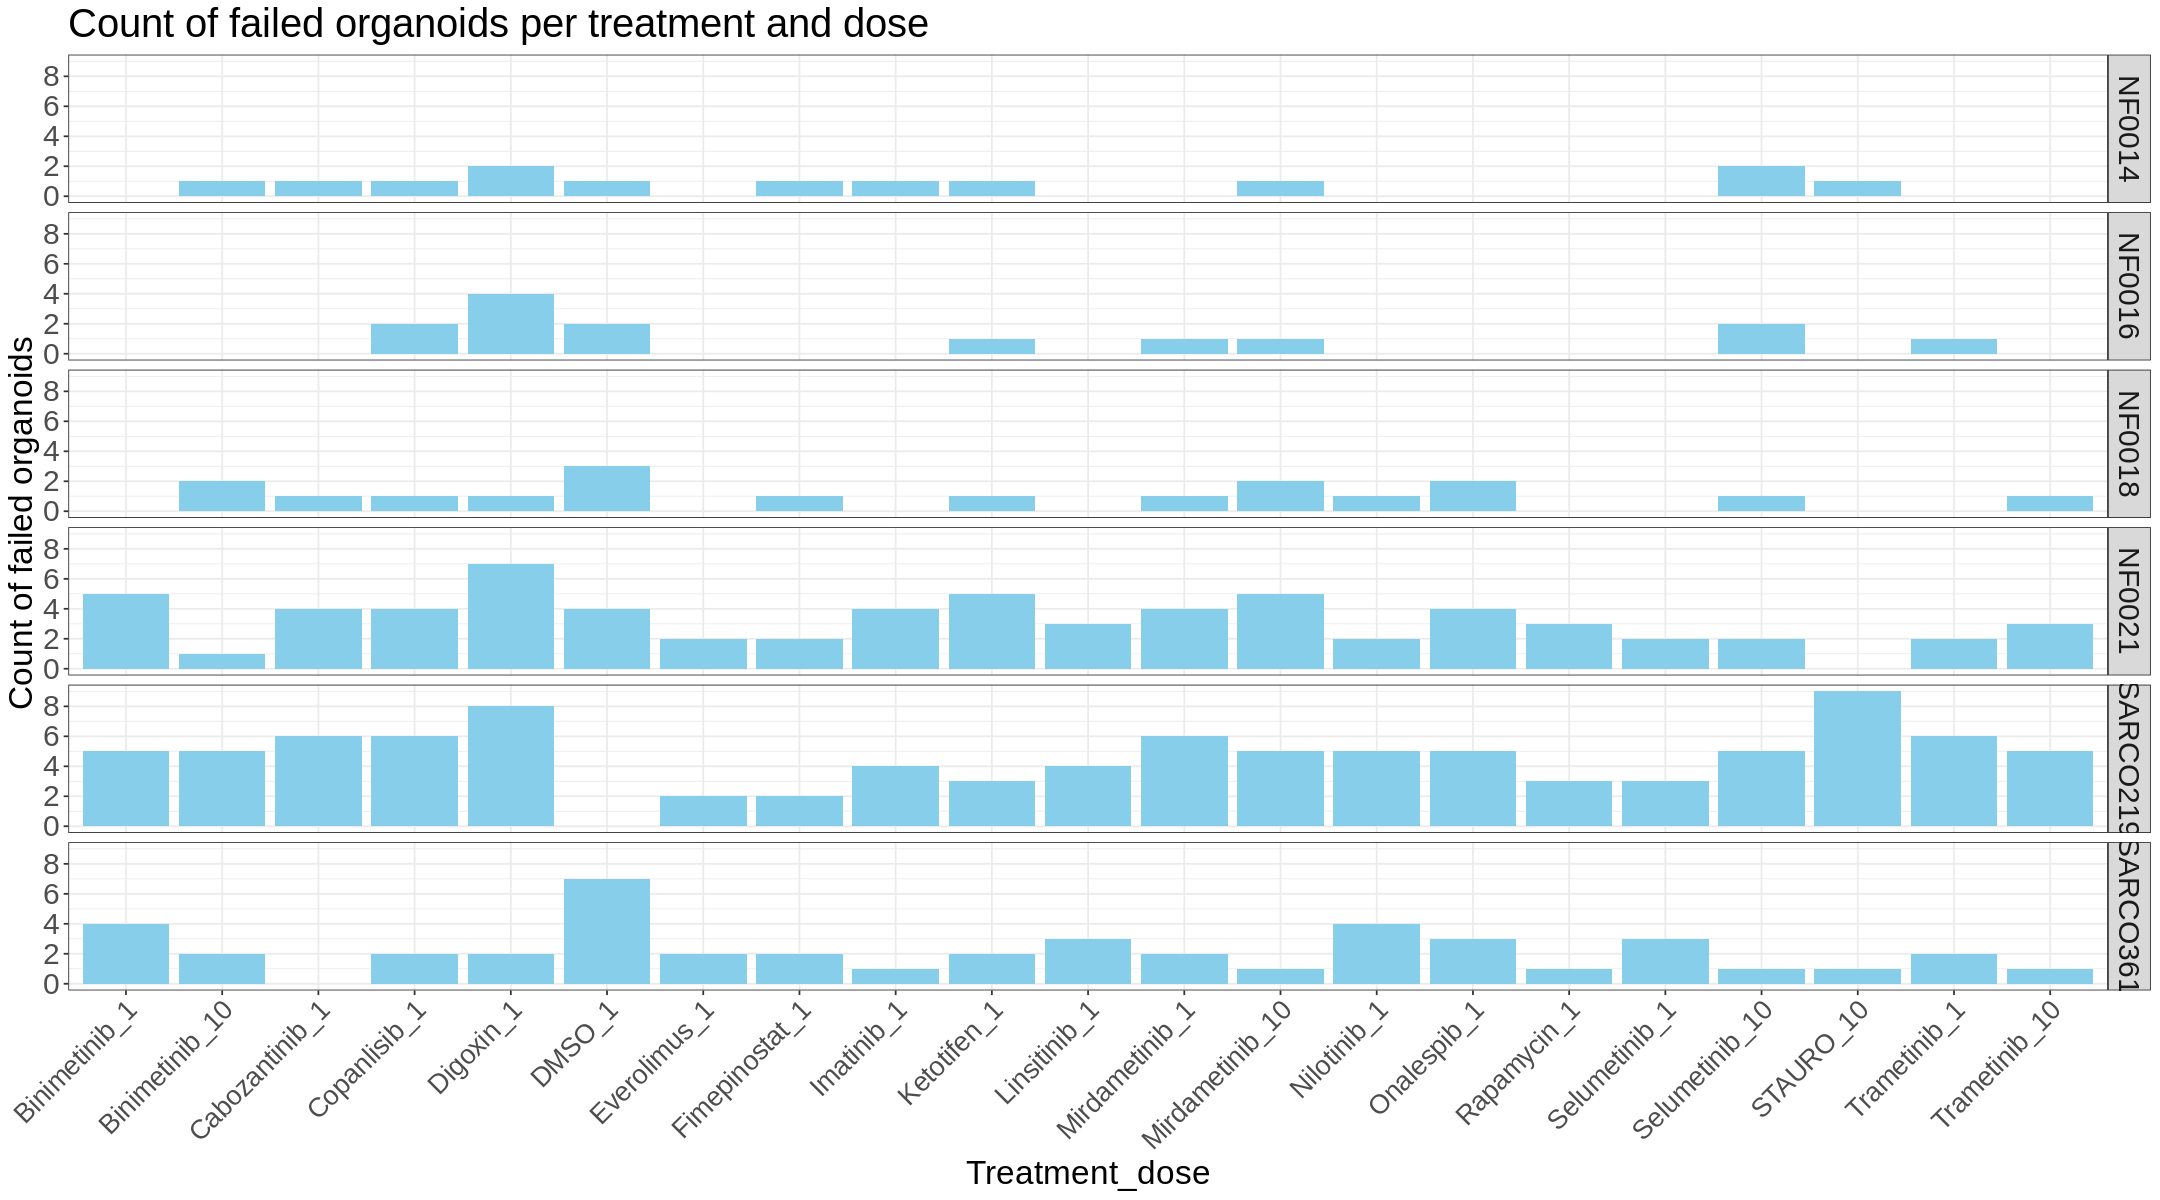

In [19]:
# Set a single color for all bars
uniform_color <- "#87CEEB" # Pastel blue as an example

# Set width and height
width <- 18
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

# Create the bar plot
treatment_dose_plot <- ggplot(treatment_dose_counts, aes(x = Treatment_Dose, y = failed_organoid_count, fill = Metadata_Plate)) +
    geom_bar(stat = "identity", fill = uniform_color) +
    labs(
        title = "Count of failed organoids per treatment and dose",
        x = "Treatment_dose",
        y = "Count of failed organoids"
    ) +
    theme_bw() +
    facet_grid(Metadata_Plate ~ .) +
    scale_y_continuous(breaks = seq(0, 9, by = 2), limits = c(0, 9)) + # Set y-axis limit from 0 to 9
    theme(
        plot.title = element_text(size = 24),
        axis.title = element_text(size = 20),
        axis.text.y = element_text(size = 18),
        axis.text.x = element_text(size = 16, angle = 45, hjust = 1),
        legend.position = "none",
        strip.text = element_text(size = 18)
    )

# Show plot
print(treatment_dose_plot)

# Save plot
ggsave(file.path(figures_dir, "failed_organoid_count_treatment_dose.png"), plot = treatment_dose_plot, width = width, height = height, dpi = 500)


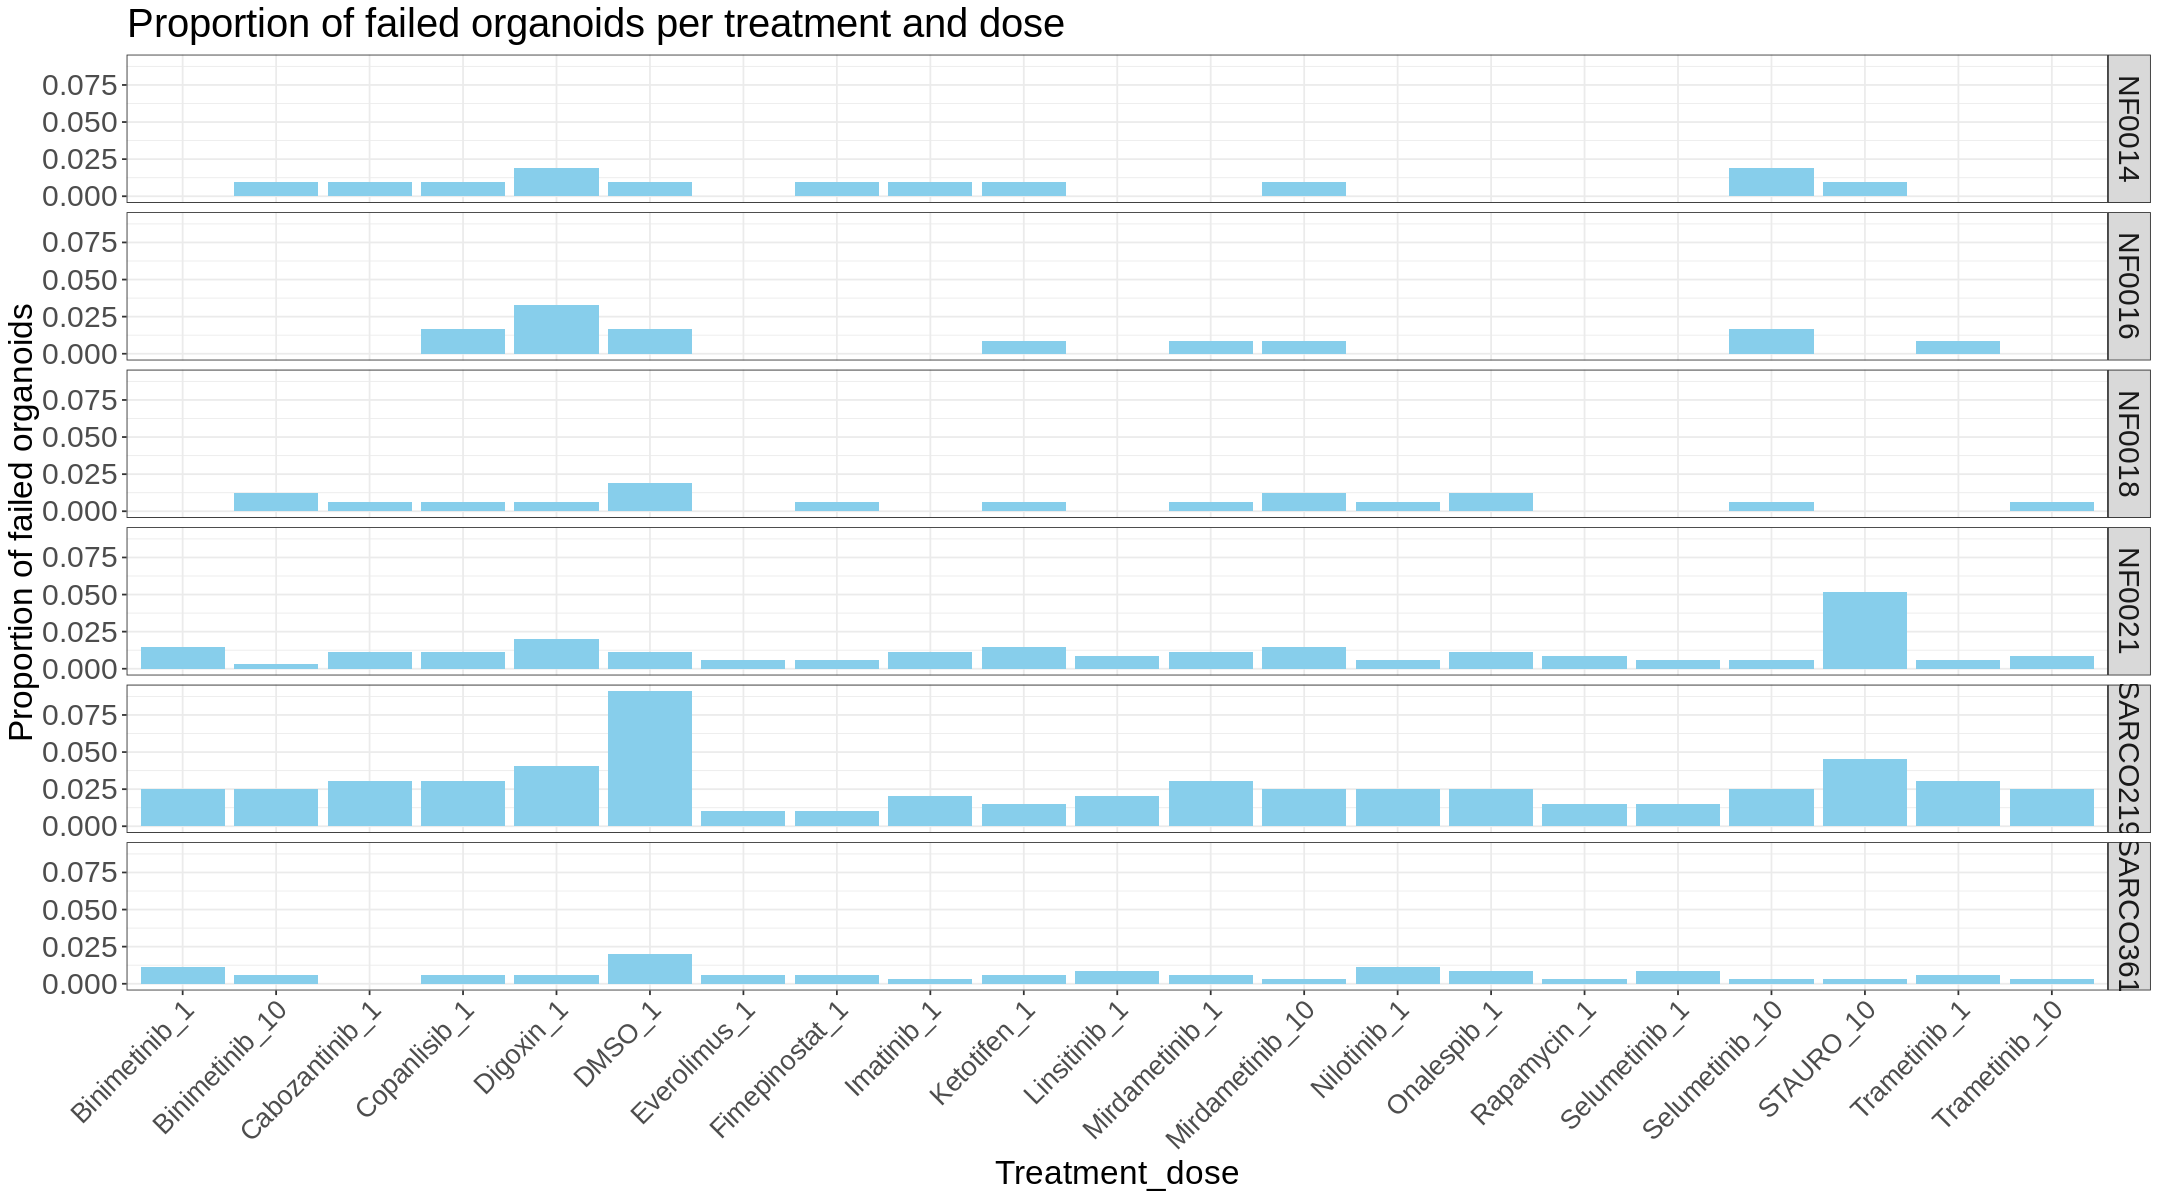

In [20]:
# Set a single color for all bars
uniform_color <- "#87CEEB" # Pastel blue as an example

# Set width and height
width <- 18
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

# Create the bar plot
treatment_dose_plot <- ggplot(treatment_dose_counts, aes(x = Treatment_Dose, y = proportion_failed, fill = Metadata_Plate)) +
    geom_bar(stat = "identity", fill = uniform_color) +
    labs(
        title = "Proportion of failed organoids per treatment and dose",
        x = "Treatment_dose",
        y = "Proportion of failed organoids"
    ) +
    theme_bw() +
    facet_grid(Metadata_Plate ~ .) +
    theme(
        plot.title = element_text(size = 24),
        axis.title = element_text(size = 20),
        axis.text.y = element_text(size = 18),
        axis.text.x = element_text(size = 16, angle = 45, hjust = 1),
        legend.position = "none",
        strip.text = element_text(size = 18)
    )

# Show plot
print(treatment_dose_plot)

# Save plot
ggsave(file.path(figures_dir, "failed_organoid_proportion_treatment_dose.png"), plot = treatment_dose_plot, width = width, height = height, dpi = 500)
